In [69]:
import pandas as pd
import numpy as np

from datetime import date
import warnings
warnings.filterwarnings('ignore')

from plotnine import *
import folium
import matplotlib.pyplot as plt

# 1. data tidy 
칼럼명 지정, 날짜 형식 바꾸기, days_diff 칼럼 만들기, 위치정보 넣기, 포스팅 제목에 방송명과 지역명 들어간 row만 살리기

In [2]:
# 초기 tidy
def tidy(df):
    df.columns = ['방송', '식당', '방영일', '포스팅일', '제목', '주소']
    df = df[df['포스팅일'].isnull() == False]
    df['방영일'] = df['방영일'].astype(str)
    
    return df

In [3]:
# 방영일 date 형식으로 바꾸기
def get_date_from_b_date(df_column):
    b_date = []
    for data in df_column:
        year = data[:4]
        month = data[4:6]
        day = data[6:8]
        single_date = date(int(year), int(month), int(day))
        b_date.append(single_date)

    return pd.Series(b_date)

In [4]:
# 포스팅일 date 형식으로 바꾸기
def get_date_from_p_date(df_column):
    p_date = []
    for data in df_column:
        date_components = data.split('.')
        year = date_components[0]
        month = date_components[1]
        day = date_components[2]
        single_date = date(int(year), int(month), int(day))
        p_date.append(single_date)
    return pd.Series(p_date)

In [5]:
# 방영일과 포스팅일 날짜 차이 구하기
def get_days_diff(col_days_diff, col_b_day, col_p_day):
    col_days_diff = col_p_day - col_b_day
    col_days_diff = col_days_diff.astype(str).str.findall(r'(\-?\d+)\s')
    days_list = []
    for days in col_days_diff:
        days_list.append(int(days[0]))
    return days_list

In [6]:
# 위치정보 넣기
dining_areas = {
'대풍만두' :'안동' ,'큰바다해물아구찜' :'일산/파주' ,'여인천하조개구이' :'인천/을왕리/영종도' ,'제일정육정식당' :'용문/오산' ,'칡산에' :'원주' ,'동남집' :'구디/가산' ,
'찜혜화동' :'대학로/혜화' ,'통큰손칼국수' :'인천/소랲포구' ,'송씨 뼈대 있는 짬뽕' :'강원도/원주/횡성' ,'행복한 콩박사' :'오산/양산/병점' ,'아이포차' :'부천/역곡' ,'김관석의 탐라돈' :'신촌/홍대' ,
'청송숯불갈비' :'대구/대명' ,'세친구 족발이야기' :'인천/계양/작전' ,'요망진 도세기' :'제주/애월/당산' ,'돈까스잔치' :'동빙고/용산/동부' ,'송영선할머니갈비집' :'포천' ,'136생고기' :'인천/작전동/동부' ,
'영월애곤드레' :'인천/부천' ,'빽갈비1983' :'논현/강남구청' ,'마포참치' :'마포' ,'옛골매운갈비김치찜' :'성남/상대원/모란' ,'토가' :'강화도' ,'짜글이식당' :'충주/청주' ,
'번개맞은흑돼지' :'제주/서귀포' ,'섭지향' :'제주/성산/섭지코지' ,'꼬치파이터' :'전주/객사' ,'용두동쭈꾸미' :'동대문' ,'소담골' :'동두천/강화도' ,'광명소고기순대국' :'광명/철산' ,
'신촌해물칼국수' :'신촌/홍대' ,'더행복' :'상암' ,'편가네 간장게장' :'강화도' ,'행복한 곰탕' :'대전/유성/세종' ,'밴댕이소갈딱지삼겹살강가네' :'진해/창원' ,'천마루' :'무주' ,
'군자네' :'대흥/마포' ,'현래장' :'마포' ,'시내식당' :'광양/여수' ,'금목서회관' :'광양' ,'평창면옥' :'평창' ,'더코너키친' :'옥수/평창' ,'구로식당 본점' :'구디/구로' ,'영빈관' :'원주' ,'맛자랑' :'경주' ,'할머니 묵집' :'파주' ,'구옹진식당' :'서산/충남' ,'강화해신탕' :'강화' ,
'속초어시장' :'일산' ,'약산궁 능이버섯백숙' :'포천/경기' ,'속초해물보쌈전골' :'속초' ,'제주미돈' :'인천/소래' ,'오시오집' :'영등포/여의도' ,'계림식당' :'종로' ,
'옛골할머니감자탕순대국' :'일산' ,'청담추어정' :'성남/시흥' ,'까치기사식당' :'인천/십정동' ,'시골본가집' :'남양주' ,'갈비구락부' :'울산/언양' ,'반저' :'대학로/혜화' ,
'소문난 곱창' :'마천/송파' ,'당구대통철판삼겹살' :'부산/기장' ,'전주집' :'종로/을지로' ,'원조추어탕' :'강남/역삼/신논현' ,'샤리' :'부산/서면' ,'이태리국시' :'대전/둔산' ,
'쑥고개부대찌개' :'안성/칠곡' ,'꽃삼' :'아산/신용화' ,'네모오징어 도곡본점' :'매봉/도곡' ,'연호정칼국수' :'김포/강화' ,'진심인게야' :'일산/풍동' ,'스앤샤 홍대본점' :'홍대' ,
'취향왕짬뽕' :'안양/시흥' ,'쇠뫼기' :'경기/광주/퇴촌' ,'바다담은 해물 손칼국수' :'원당/일산/고양' ,'강릉아구찜' :'신촌/이대' ,'미스테이크룸' :'이태원' ,'고기한점 달빛한점' :'하단/건대/광진구' ,
'하선재 간장게장' :'송파/방이/잠실' ,'이태원 우육미엔' :'이태원/한남' ,'푸른초장' :'충정' ,'어부네 횟집' :'마포' ,'철판패밀리' :'의정부' ,'해신247' :'아주/거제' ,
    
# 맛있는 녀석들
    '내호냉면' : '부산', '한방장어구이' : '부산', '김영자 나주곰탕' : '신림', '강촌원조쭈꾸미' : '양재', '바다회사랑' : '홍대/연남/마포', '디 안다만' : '양재', '화수목' : '분당/서현', '매화반점' : '건대/자양', 
'개미집' : '건대/화양', '사당삼겹살' : '남현', '등촌최월선칼국수' : '등촌', '야바이' : '신촌/창천', '현대북어찜' : '역삼', '순라길' : '권농/종로', '무등산' : '청담', '도셰프' : '반포/논현', 
'정통부대고기' : '의정부', '먹깨비' : '동대문/장안', '청운누룽지백숙' : '의왕', '포브라더스' : '도곡/강남', '수협회센터' : '완도', '두메향기 산' : '양평', '진흥관' : '김포', '건대통골뱅이' : '강남/논현', 
'그릭슈바인' : '강남/논현', '일억조식당' : '완도', '매봉골 황제능이버섯' : '남양주', '바람아래돌꽃게장' : '고양', '순천만가든' : '순천', '남문식당' : '강진', '보리네 생고깃간' : '안성', '소문난 잔치국수' : '공릉', 
'경포' : '성남', '미소복 양평해장국' : '갈현', '뿌자2' : '을지로', '코리아노스키친' : '용산/이태원', '조선김밥' : '종로/소격/삼청', '봉청동진순자김밥' : '봉천', '장하촌' : '가양', '강남목장' : '강남/역삼', 
'홍어랑 민어랑' : '불광', '박달재 자연식당' : '양재', '만복기사식당' : '마포/망원', '명가막국수' : '춘천', '개화옥 등심' : '신사', '텍사스 데 브라질' : '반포/고속터미널', '한옥집' : '냉천/서대문', '우정낙지' : '종로/서린/무교', 
'팔팔민물장어' : '강남/반포', '황금복국' : '강남/서초', '샘밭막국수' : '춘천', '원조숯불닭불고기' : '춘천', '산밑할머니묵집' : '대전', '진로집' : '대전', '사돈집' : '속초', '동명항게찜' : '속초', '대동할매국수' : '김해', '김정식의 삼일뒷고기' : '김해', 
'속씨원한 대구탕' : '부산', '한량' : '부산', '시오' : '서대문/연희', '샤이바나' : '코엑스/동대문/분당/서현/고양/판교/상수/세종/도담/스타필드/광화문/강남/삼성/아쿠아리움/합정/송도/홍대/가산/시청/청계천/일산/삼청동/스타시티/DDP/부산/서면/중구/을지로/삼송', 
'원조다래솥뚜껑' : '동두천', '오륙하우스' : '동두천', '백담황태구이' : '인제/백담사', '자작나무집' : '인제/원대리', '전주중앙회관' : '명동/충무로', '메이탄' : '시청/서초/강남/신당/왕십리/신논현/중구/상계/서대문/천안/노원/상계/마포/공덕/선유도/공덕/우장산/당산/강서/발산/청정로/', 
'미타우동' : '신천/잠실/삼전', '도마' : '광화문/종로/익선/안국/인사', '텐마루' : '가산/금천', '라화쿵부' : '신촌/건대/구월/남대문/명동/이대/외대/이문/대림/동대문/강남/영등포/울산', 
'소백산' : '양재', '건대황소곱창' : '건대/화양', '박승광손칼국수' : '김포', '큰손참붕어찜' : '김포', '나폴레옹 과자점' : '성북', '류재은베이커리' : '파주', '시청/서초/강남/신당/왕십리/신논현/중구/상계/서대문/천안/노원/상계/마포/공덕/선유도/공덕/우장산/당산/강서/발산/충정로/아현' : '광주', 

# 수요미식회
  '오통영':'청담/압구정/이촌', '안동장':'을지로', '평양집':'용산/삼각지/이태원', '까사디노아':'연남동', '덕자네 방앗간':'신논현/강남/압구정/서초', '루비떡볶이':'압구정/신사/청담', 
'참식당':'마포', '갯바위':'서울대입구/봉천', '포담':'서초/통인', '따빠스구르메':'서초/통인', '고래불':'역삼', '영주묵호문어집':'영주', '오돌':'영등포/여의도/당산', '미갈매기살':'종로', '안즈':'명동/을지로', '정돈':'대학로/혜화', '다미':'여의도', '대원식당':'용산/삼각지', 
'개화옥':'압구정/신사/가로수길/청담', '대복집':'광화문/시청/경복궁', '멍게가':'통영', '수정식당':'통영', '주은감자탕':'잠실/송파/삼전', '닭한마리감자탕':'신사', 
'금홍':'이촌/신사', '아지겐':'용산/이촌', '서일농원 솔리':'안성', '목향원':'남양주', '서울여관식당':'청송', '오복손두부':'광주/남한산성', '다운타우너':'이태원/한남동/청담/압구정', '카퍼룸':'선정릉/삼성/강남', '우정회관':'고창', '연기식당':'고창', '아티장베이커스':'서래마을/한남동', '악소':'한남동', 
'부첼리하우스':'용산/한남동', '로리스더프라임립':'강남', '엽기꼼닭발':'왕십리', '재구네 닭발':'신당', '비야게레로':'강남/삼성', '바토스':'이태원/신사/가로수길/잠실', 
'정인면옥':'여의도', '함흥에겨울냉면':'동대입구/장충동', '브로이하우스 바네하임':'노원/공릉', '갓포치유':'압구정/도산공원/신사', '화선횟집':'인천/신포', '병우네':'삼청/팔판동', 
'남도사계 고운님':'삼성/대치/강남', '동해오징어보쌈':'안양', '옛골':'강남/역삼/청계산', '성일 정육점':'성수/뚝섬', '산성대가':'남한산성', '진남포면옥':'약수', 
'팜티진':'왕십리', '사이공리':'노량진', '미쓰양꼬치':'대치/선릉', '명봉샤브샤브양꼬치':'건대/자양', '탑동물항식당':'제주/탑동', '네거리식당':'제주/서귀포', '안주마을':'서촌/경복궁', 
'짱이네 산곰장어':'논현/언주', '메종엠오':'방배/서래마을/내방', '쉐즈롤':'양평/서종/문호리', '논밭골':'봉천/서울대입구', '배꼽집':'논현/여의도/백석/일산/상암/강남/마곡/발산', '월성식당':'강릉/주문진/신월성', 
'강릉감자옹심이':'강릉', '제주도 아줌마네집':'둔촌/강동/성내', '신복촌':'여의도', '대림동 삼거리먼지막순댓국':'대림', '농민백암순대':'선릉/대치/강남', '대감왕족발':'압구정/강남/신사', 
'와글와글족':'공항동/김포/송정', '라이차이':'공항동/당산/강서', '대관원':'당산/영등포', '백부장집 닭 한 마리':'신도림/마포/구로/망원', '강촌 숯불 닭갈비':'신도림/마포/구로/망원', '구복만두':'남영/숙대/용산', '취천루':'서촌/경복궁/명동', '삐아프':'가로수길/신사', 
'끌라시끄':'분당/정자', '테라13':'청담/압구정/학동사거리', '레스쁘아 뒤 이브':'청담/압구정/학동사거리'
}

In [7]:
sangsang = pd.read_csv('data/sangsang_2017_90days.csv')
suyo = pd.read_csv('data/suyo_2017_90days.csv')
mashit = pd.read_csv('data/mashit_2017_90days.csv')

In [8]:
sangsang.columns = ['방송', '식당', '방영일', '포스팅일', '제목', '주소']
sangsang['방송'] = '생생'

In [9]:
def final_tidy(df):
    df = tidy(df)
    df['방영일'] = get_date_from_b_date(df['방영일'])
    df['포스팅일'] = get_date_from_p_date(df['포스팅일'])
    df['days_diff'] = pd.Series()
    df['days_diff'] = get_days_diff(df['days_diff'], df['방영일'], df['포스팅일'])
    df['지역'] = df['식당'].map(dining_areas).astype(str)
    tidy_df = df.loc[df.apply(lambda r: ((any(area in r[4] for area in r[7].split('/'))) | (r[0] in r[4])), axis=1)]
    return tidy_df    

In [10]:
# days_diff 칼럼 생성, 기준에 맞는 tidy하기
sangsang_area = final_tidy(sangsang)
suyo_area = final_tidy(suyo)
mashit_area = final_tidy(mashit)

In [11]:
# 타이디 전/후의 데이터 갯수 차이 (방송명이나 지역명이 블로그 포스팅의 제목에 들어가있는 경우만 살림)
print('생생정보통', sangsang.shape, sangsang_area.shape)
print('수요미식회', suyo.shape, suyo_area.shape)
print('맛있는 녀석들', mashit.shape, mashit_area.shape)

생생정보통 (28463, 6) (5229, 8)
수요미식회 (35712, 6) (12010, 8)
맛있는 녀석들 (33662, 6) (8360, 8)


In [12]:
# tidy된 데이터 저장
sangsang_area.to_csv('data/sangsang_tidy.csv', index = False)
suyo_area.to_csv('data/suyo_tidy.csv', index = False)
mashit_area.to_csv('data/mashit_tidy.csv', index = False)

# 2. 필요한 칼럼 만들기
방송전, 방송후, 방송당일 칼럼 만들어 방송 전/후의 변화 보기

In [13]:
from plotnine import *

# 방송전/방송당일/방송후 칼럼 생성하는 함수
def get_before_after(df):
    df['cnt'] = 1
    df['방송전'] = df['days_diff'] < 0
    df['방송후'] = df['days_diff'] > 0
    df['방송당일'] = df['days_diff'] == 0

    df['방송전'] = df['방송전'].astype(int)
    df['방송후'] = df['방송후'].astype(int)
    df['방송당일'] = df['방송당일'].astype(int)
    
    return df

# 방송 전/후의 추이를 볼 수 있도록 그래프를 그려주는 함수
def graph_after(df):
    df_group = df.groupby(['식당','days_diff']).sum().sort_values(by='days_diff').reset_index()
    df_group = df_group.groupby('days_diff').sum().reset_index()

    (ggplot(df_group)
    + aes(x='days_diff', y='cnt')
     + ggtitle(df['방송'][0])
     + geom_bar(stat='identity', position='dodge')
     + theme(text=element_text(family='NanumGothic'))
    ).draw()

## 1) 생생정보통

In [14]:
sangsang_area = get_before_after(sangsang_area)
sangsang_area.groupby('식당').sum().describe()

# 생생정보통은 가장 적은 포스팅 수의 증가를 보인다
# 방송전/ 방송 후를 30일로 나누면 방송 전/후의 일평균 포스팅 수를 볼 수 있다. 

,days_diff,cnt,방송전,방송후,방송당일
count,83.000000,83.000000,83.000000,83.000000,83.000000
mean,66.734940,63.000000,21.228916,26.216867,15.554217
std,482.245664,56.726988,27.444101,28.161576,7.396857
min,-1333.000000,1.000000,0.000000,0.000000,0.000000
25%,-77.000000,30.000000,5.000000,10.500000,12.000000
50%,60.000000,49.000000,11.000000,19.000000,17.000000
75%,315.000000,75.500000,30.000000,29.000000,21.000000
max,1785.000000,352.000000,165.000000,167.000000,27.000000


/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: Us

/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: Us

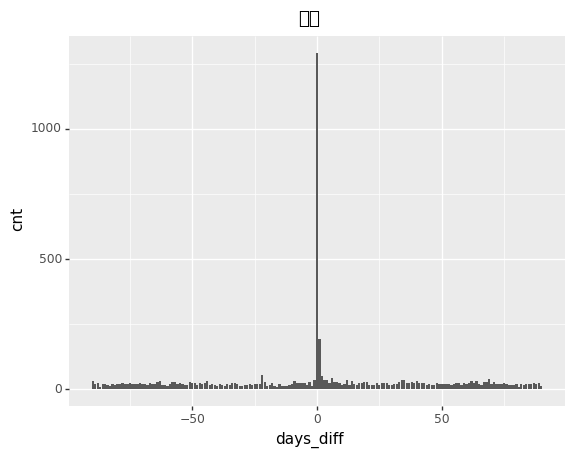

In [15]:
# to_do : 예빈
# 평균값으로 그려주기
# y의 max값 맞춰주기
graph_after(sangsang_area)

## 2) 수요미식회

In [16]:
suyo_area = get_before_after(suyo_area)
suyo_area.groupby('식당').sum().describe()

# 수요미식회는 아주 폭발적인 포스팅 수 증가를 보인다. 거의 3배 이상의 증가이며
# 방송 당일의 평균 포스팅 수도 가장 많다. 

,days_diff,cnt,방송전,방송후,방송당일
count,84.000000,84.000000,84.000000,84.000000,84.000000
mean,1598.059524,142.976190,33.428571,91.297619,18.250000
std,1505.374775,133.840849,55.376539,79.034350,8.877853
min,-641.000000,2.000000,0.000000,2.000000,0.000000
25%,547.250000,67.000000,6.750000,49.750000,12.750000
50%,1259.000000,103.500000,15.500000,70.000000,17.500000
75%,2232.000000,160.000000,31.250000,109.250000,24.250000
max,10440.000000,887.000000,311.000000,558.000000,43.000000


/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: Us

/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: Us

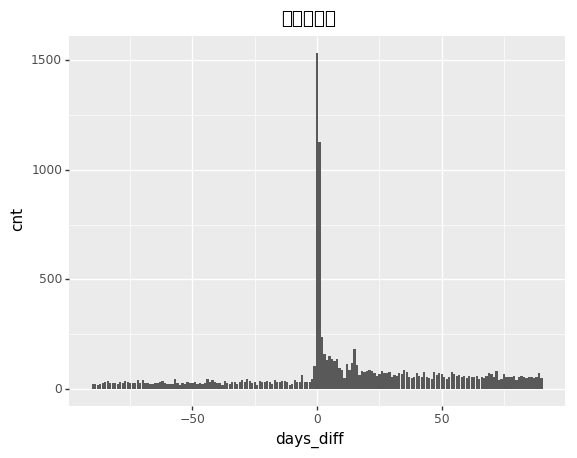

In [17]:
graph_after(suyo_area)

## 3) 맛있는 녀석들

In [18]:
mashit_area = get_before_after(mashit_area)
mashit_area.groupby('식당').sum().describe()

,days_diff,cnt,방송전,방송후,방송당일
count,79.000000,79.000000,79.000000,79.000000,79.000000
mean,359.620253,105.822785,43.772152,59.227848,2.822785
std,1859.107425,171.268777,81.197283,90.820187,2.535691
min,-3010.000000,1.000000,0.000000,1.000000,0.000000
25%,-5.000000,20.500000,3.000000,15.000000,1.000000
50%,228.000000,49.000000,13.000000,31.000000,2.000000
75%,558.500000,109.000000,40.000000,59.000000,4.000000
max,14298.000000,1000.000000,504.000000,498.000000,12.000000


/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: Us

/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jiyoung/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: Us

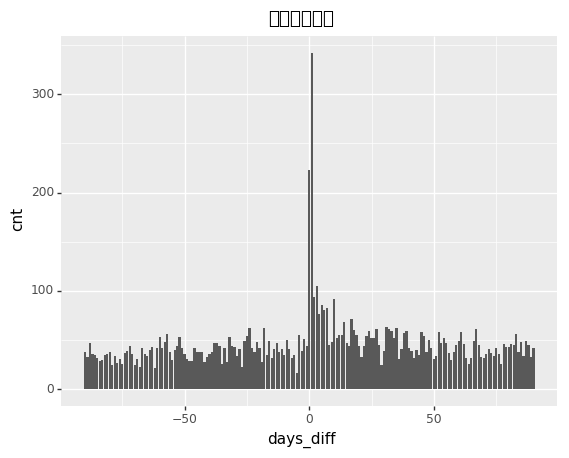

In [19]:
graph_after(mashit_area)

# 3. 가장 수혜를 많이 받은 식당 

- '수혜를 많이 받았다'는 '포스팅 수가 가장 많이 증가한 비율'을 의미한다.
- 수혜 식당을 선정하는 기준은 포스팅 증가 분이 가장 많은 식당 10위와
- 증가율이 가장 높은 식당 10위 중 가장 먼저 중복된 식당으로 선정한다.

In [20]:
# 증가분과 증가율을 구하는 함수
def get_increased_amount(df):
    df_best = df.groupby('식당')['식당', '방송전', '방송후'].sum()
    df_best['증가분'] = df_best['방송후'] - df_best['방송전']
    df_best['증가율'] = 100 * df_best['증가분'] / df_best['방송전']
    
    return df_best

In [21]:
# 방송별 증가분/증가율 구하기
suyo_best = get_increased_amount(suyo_area).reset_index()
sangsang_best = get_increased_amount(sangsang_area).reset_index()
mashit_best = get_increased_amount(mashit_area).reset_index()

In [90]:
# 방송 전 포스팅이 0인 컬럼 제외
# 방송 전 포스팅이 0인 경우 증가율 구하기 어렵고, 포스팅 수가 적은 업체는 분석에서 

suyo_best = suyo_best.drop(suyo_best.loc[suyo_best['방송전'] == 0].index.values)
sangsang_best = sangsang_best.drop(sangsang_best.loc[sangsang_best['방송전'] == 0].index.values)
mashit_best = mashit_best.drop(mashit_best.loc[mashit_best['방송전'] == 0].index.values)
mashit_best.shape

(70, 5)

In [26]:
mashit_best.loc[mashit_best['방송전'] == 0]

,식당,방송전,방송후,증가분,증가율


## 1) 수요미식회

In [27]:
suyo_best.sort_values(by=['증가율'], ascending = False).head()

,식당,방송전,방송후,증가분,증가율
19,대림동 삼거리먼지막순댓국,2,42,40,2000.0
74,참식당,2,42,40,2000.0
24,따빠스구르메,2,38,36,1800.0
47,성일 정육점,4,76,72,1800.0
65,우정회관,3,51,48,1600.0


In [34]:
# 가장 포스팅수의 갯수가 늘어난 식당
suyo_best.sort_values('증가분', ascending=False).head(10)

,식당,방송전,방송후,증가분,증가율
15,다운타우너,311,558,247,79.421222
22,덕자네 방앗간,11,185,174,1581.818182
13,농민백암순대,51,170,119,233.333333
80,평양집,47,160,113,240.425532
71,주은감자탕,18,129,111,616.666667
28,루비떡볶이,12,121,109,908.333333
48,수정식당,18,127,109,605.555556
1,강릉감자옹심이,177,278,101,57.062147
82,함흥에겨울냉면,12,108,96,800.000000
79,팜티진,32,126,94,293.750000


In [35]:
# 방송 전에 비해 방송 후의 포스팅수가 가장 많이 늘어난 식당
suyo_best.sort_values('증가율', ascending=False).head(10)

,식당,방송전,방송후,증가분,증가율
19,대림동 삼거리먼지막순댓국,2,42,40,2000.000000
74,참식당,2,42,40,2000.000000
24,따빠스구르메,2,38,36,1800.000000
47,성일 정육점,4,76,72,1800.000000
65,우정회관,3,51,48,1600.000000
22,덕자네 방앗간,11,185,174,1581.818182
67,재구네 닭발,6,93,87,1450.000000
37,백부장집 닭 한 마리,4,53,49,1225.000000
33,미갈매기살,8,99,91,1137.500000
42,삐아프,4,49,45,1125.000000


In [30]:
# 와글와글족, 영주목호문어집이 정말 방송 전에 포스팅 수가 0개였는지 확인이 필요하다
# 방송 전에 포스팅 수가 10개 이상인 식당만 대상으로 한다면?
suyo_best[suyo_best['방송전']>10].sort_values('증가율', ascending=False).head(3)

,식당,방송전,방송후,증가분,증가율
22,덕자네 방앗간,11,185,174,1581.818182
28,루비떡볶이,12,121,109,908.333333
82,함흥에겨울냉면,12,108,96,800.000000


In [89]:
suyo_best[suyo_best['증가분']>58].sort_values('증가율', ascending=False).head(3)

,식당,방송전,방송후,증가분,증가율
47,성일 정육점,4,76,72,1800.000000
22,덕자네 방앗간,11,185,174,1581.818182
67,재구네 닭발,6,93,87,1450.000000


수요미식회의 가장 수혜를 많이 받은 식당은 **덕자네 방앗간**

In [82]:
suyo_best['증가분'].sum()/ suyo_best['증가분'].count()

58.8780487804878

## 2) 맛있는녀석들

In [37]:
mashit_best.sort_values(by=['증가분'], ascending = False).head()

,식당,방송전,방송후,증가분,증가율
43,샤이바나,300,498,198,66.000000
20,라화쿵부,229,339,110,48.034934
34,박승광손칼국수,21,82,61,290.476190
57,자작나무집,97,145,48,49.484536
0,강촌원조쭈꾸미,7,43,36,514.285714


In [47]:
# 가장 포스팅수의 갯수가 늘어난 식당
mashit_best.sort_values('증가분', ascending=False).head(20)

,식당,방송전,방송후,증가분,증가율
43,샤이바나,300,498,198,66.000000
20,라화쿵부,229,339,110,48.034934
34,박승광손칼국수,21,82,61,290.476190
57,자작나무집,97,145,48,49.484536
0,강촌원조쭈꾸미,7,43,36,514.285714
4,건대황소곱창,22,58,36,163.636364
13,대동할매국수,30,62,32,106.666667
10,나폴레옹 과자점,9,37,28,311.111111
15,도셰프,43,69,26,60.465116
63,진흥관,6,31,25,416.666667


In [48]:
# 방송 전에 비해 방송 후의 포스팅수가 가장 많이 늘어난 식당
mashit_best.sort_values('증가율', ascending=False).head(20)

,식당,방송전,방송후,증가분,증가율
33,박달재 자연식당,1,14,13,1300.000000
23,매봉골 황제능이버섯,1,12,11,1100.000000
38,뿌자2,1,9,8,800.000000
11,남문식당,2,18,16,800.000000
64,청운누룽지백숙,3,25,22,733.333333
2,개화옥 등심,1,7,6,600.000000
69,텐마루,4,28,24,600.000000
54,원조다래솥뚜껑,3,21,18,600.000000
0,강촌원조쭈꾸미,7,43,36,514.285714
59,전주중앙회관,3,18,15,500.000000


In [81]:
# 와글와글족, 영주목호문어집이 정말 방송 전에 포스팅 수가 0개였는지 확인이 필요하다
# 방송 전에 포스팅 수가 10개 이상인 식당만 대상으로 한다면?
mashit_best[mashit_best['증가분']>16].sort_values('증가율', ascending=False).head(3)

,식당,방송전,방송후,증가분,증가율
64,청운누룽지백숙,3,25,22,733.333333
54,원조다래솥뚜껑,3,21,18,600.000000
69,텐마루,4,28,24,600.000000


In [80]:
mashit_best['증가분'].sum()/ mashit_best['증가분'].count()

16.185714285714287

맛있는녀석들의 가장 수혜를 많이 받은 식당은 **강촌원조쭈꾸미**

## 3) 생생정보통

In [52]:
sangsang_best.sort_values(by=['증가율'], ascending = False).head()

,식당,방송전,방송후,증가분,증가율
45,약산궁 능이버섯백숙,1,8,7,700.000000
0,136생고기,4,31,27,675.000000
17,대풍만두,1,6,5,500.000000
68,청송숯불갈비,5,22,17,340.000000
32,세친구 족발이야기,3,13,10,333.333333


In [57]:
# 가장 포스팅수의 갯수가 늘어난 식당
sangsang_best.sort_values('증가분', ascending=False).head(10)

,식당,방송전,방송후,증가분,증가율
58,이태원 우육미엔,61,91,30,49.180328
0,136생고기,4,31,27,675.000000
31,섭지향,23,44,21,91.304348
30,샤리,43,63,20,46.511628
42,신촌해물칼국수,75,94,19,25.333333
24,미스테이크룸,55,73,18,32.727273
68,청송숯불갈비,5,22,17,340.000000
5,고기한점 달빛한점,14,31,17,121.428571
50,영월애곤드레,102,118,16,15.686275
64,찜혜화동,35,51,16,45.714286


In [56]:
# 방송 전에 비해 방송 후의 포스팅수가 가장 많이 늘어난 식당
sangsang_best.sort_values('증가율', ascending=False).head(10)

,식당,방송전,방송후,증가분,증가율
45,약산궁 능이버섯백숙,1,8,7,700.000000
0,136생고기,4,31,27,675.000000
17,대풍만두,1,6,5,500.000000
68,청송숯불갈비,5,22,17,340.000000
32,세친구 족발이야기,3,13,10,333.333333
16,당구대통철판삼겹살,3,12,9,300.000000
10,금목서회관,1,4,3,300.000000
39,쇠뫼기,3,11,8,266.666667
15,네모오징어 도곡본점,2,7,5,250.000000
55,용두동쭈꾸미,6,17,11,183.333333


In [92]:
# 와글와글족, 영주목호문어집이 정말 방송 전에 포스팅 수가 0개였는지 확인이 필요하다
# 방송 전에 포스팅 수가 10개 이상인 식당만 대상으로 한다면?
sangsang_best[sangsang_best['방송전']>4].sort_values('증가율', ascending=False).head(3)

,식당,방송전,방송후,증가분,증가율
68,청송숯불갈비,5,22,17,340.000000
55,용두동쭈꾸미,6,17,11,183.333333
75,평창면옥,8,22,14,175.000000


In [91]:
sangsang_best['증가분'].sum()/sangsang_best['증가분'].count()

4.901234567901234

생생정보통의 가장 수혜를 많이 받은 식당은 **136 생고기**

# 4. Box Plot 그려보기

In [67]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus'] = False

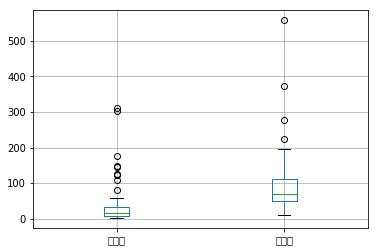

In [68]:
suyo_best.boxplot(column=['방송전', '방송후'])

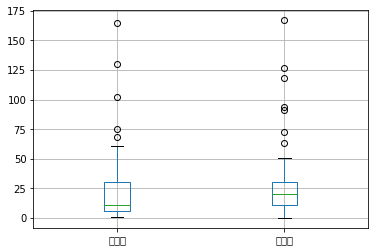

In [70]:
sangsang_best.boxplot(column=['방송전', '방송후'])

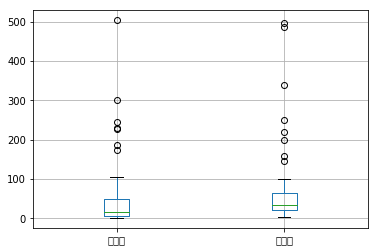

In [71]:
mashit_best.boxplot(column=['방송전', '방송후'])